In [1]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.3.1/en_core_web_md-2.3.1.tar.gz

     |████████████████████████████████| 50.8MB 83kB/s 
     |████████████████████████████████| 10.0MB 222kB/s 
     |████████████████████████████████| 2.1MB 42.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.3.1-cp36-none-any.whl size=50916643 sha256=d23210fb2ef70259cf0b1119e4b308476e94683085eb752a48bc87d69b73846a
  Stored in directory: /root/.cache/pip/wheels/6e/65/3a/34cdc26d4084d1d1f1e2ec9914964759ea17aa382c53a57d9f
Successfully built en-core-web-md
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [1]:
import os
import pickle

import numpy as np
import spacy

from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

*Upload submission_db.sqlite3 database*


In [2]:
from google.colab import files 
uploaded = files.upload()

Saving subreddit_db.sqlite3 to subreddit_db.sqlite3


In [4]:
import pandas as pd
import sqlite3
import numpy as np

def refresh_connection_and_cursor():
  try:
    c.close()
    conn.close()
  except: pass
  conn = sqlite3.connect('/content/subreddit_db.sqlite3')
  c = conn.cursor()
  return conn, c

conn, c = refresh_connection_and_cursor()

data = pd.read_sql_query(
    "select * from submission_table order by random() limit 100000;", 
    conn)

c.close()
conn.close()

In [10]:
print(data.shape)
data.head()

(51610, 4)


,subreddit_name,subreddit_id,title,text
0,Documentaries,2qhlh,The Art Of Making Noodles By Hand (2018)(12:10),
1,HomeImprovement,2ql97,PSA: Kidde Fire extinguisher recall,See link below:\n[Recall](https://www.cpsc.gov...
2,conspiracy,2qh4r,"To learn how the Federal Reserve Bank works, r...",
3,nottheonion,2qnts,The Teen Who Ashton Kutcher Hit With a Car Is ...,
4,literature,2qhps,Just finished The Iliad to completion for the ...,"Hey all,\n\nSo I am just a guy who just heard ..."


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51610 entries, 0 to 51609
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subreddit_name  51610 non-null  object
 1   subreddit_id    51610 non-null  object
 2   title           51610 non-null  object
 3   text            51610 non-null  object
dtypes: object(4)
memory usage: 1.6+ MB


In [12]:
data['subreddit_name'].unique()

array(['Documentaries', 'HomeImprovement', 'conspiracy', 'nottheonion',
       'literature', 'Health', 'gadgets', 'food', 'history', 'politics',
       'cars', 'WTF', 'entertainment', 'books', 'investing',
       'socialskills', 'AskReddit', 'Music', 'gaming', 'TwoXChromosomes',
       'Coronavirus', 'Cooking', 'Design', 'science', 'worldpolitics',
       'PublicFreakout', 'funny', 'JusticeServed', 'movies', 'travel',
       'programming', 'technology', 'mildlyinteresting', 'biology', 'DIY',
       'personalfinance', 'Fitness', 'worldnews', 'space',
       'MachineLearning', 'sports', 'GetMotivated', 'Parenting', 'Art',
       'news', 'camping', 'LifeProTips', 'scifi', 'Showerthoughts',
       'AdviceAnimals', 'television', 'math', 'announcements'],
      dtype=object)

*Data Wrangling*

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [49]:
def warngle(data, text_len_min=100, subreddit_num=50):
  """
  data: dataframe containg the subreddits and their categories
  text_len_min: minimum length of subreddit text required to be analyzed
  statistical trimming:
  subreddit_num: sampled number of subreddit posts in each category
  """
  print("\ndata shape: ", data.shape)

  # converting the title and text columns to string type
  data[['title', 'text']] = data[['title', 'text']].astype('str')
  
  # merge title and text
  data['joint_text'] = data[['title', 'text']].agg(' '.join, axis=1)

  # filter out non word and non space characters.
  # lower case the text and remove extra spaces
  data['joint_text'] = data['joint_text'].str.replace("[^\w\s']",' ').str.lower().apply(lambda row: ' '.join(row.split()))
  # print(data['text'][:10])


  # filter out the rows with no significant subreddit text
  data = data[[len(i)>100 for i in data['joint_text']]]
  print(f"\ndata shape after text length filter: {text_len_min}:")
  print(data.shape)


  # Plot the frequency of subreddit_name in the data set
  subid_count = data['subreddit_id'].value_counts(ascending=False)
  plt.figure(figsize=(12,5))
  # y axis is density plot
  sns.distplot(subid_count, kde=False, bins=len(data['subreddit_id'].value_counts()))
  plt.title('Subreddit category histogram')
  plt.xlabel('#of posts per subreddit category')
  plt.ylabel('# of subreddit categories')


  # filter out the subreddit_ids with low count of posts
  data = data.groupby('subreddit_id').filter(
      lambda x: (x['subreddit_id'].value_counts() > subreddit_num))
  print(f"\ndata shape after dropping low counts subreddit names: {subreddit_num}")
  print(data.shape)


  # Sample a fixed number of posts from each category
  df = data.groupby('subreddit_id', as_index=False).apply(lambda x: x.sample(
      n=subreddit_num, replace=False, random_state=1)).reset_index(level=0, drop=True)
  print(f"\ndf shape after sampling {subreddit_num} posts per subreddit category")
  print(df.shape)
  
  # Number of subreddit categories to classify on
  print(f"\n# of subreddit categories: {len(df['subreddit_id'].value_counts())}")

  return data, df


data shape:  (20368, 5)

data shape after text length filter: 100:
(20368, 5)

data shape after dropping low counts subreddit names: 100
(20368, 5)

df shape after sampling 100 posts per subreddit category
(4400, 5)

# of subreddit categories: 44


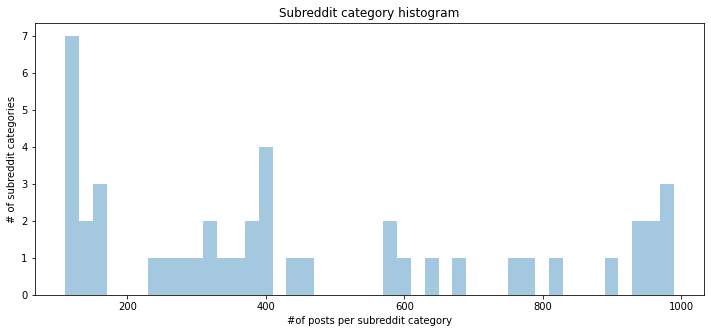

In [50]:
data, df = warngle(data, text_len_min=100, subreddit_num=100);

In [51]:
print(df.shape)
df.sample(n=5, axis=0)
df.head()

(4400, 5)


,subreddit_name,subreddit_id,title,text,joint_text
22734,politics,2cneq,Finland's millennial prime minister said Nordi...,,finland's millennial prime minister said nordi...
46935,politics,2cneq,"RBG Immediately Went There, Asked Trump Lawyer...",,rbg immediately went there asked trump lawyer ...
33142,politics,2cneq,Demands for Kushner to Resign Over 'Staggering...,,demands for kushner to resign over 'staggering...
36586,politics,2cneq,Megathread: Report States Trump Repeatedly Pre...,"""President Trump in a July phone call repeated...",megathread report states trump repeatedly pres...
37206,politics,2cneq,The Coronavirus Is the Worst Intelligence Fail...,,the coronavirus is the worst intelligence fail...


In [53]:
df['subreddit_name'].unique()

array(['politics', 'programming', 'sports', 'gaming', 'entertainment',
       'math', 'worldnews', 'technology', 'AskReddit', 'Music', 'scifi',
       'news', 'movies', 'travel', 'books', 'conspiracy', 'history',
       'television', 'Design', 'DIY', 'Cooking', 'space', 'worldpolitics',
       'Health', 'investing', 'cars', 'Documentaries', 'Parenting',
       'biology', 'literature', 'Fitness', 'camping', 'HomeImprovement',
       'personalfinance', 'announcements', 'socialskills',
       'TwoXChromosomes', 'MachineLearning', 'LifeProTips',
       'Showerthoughts', 'JusticeServed', 'Coronavirus', 'PublicFreakout',
       'science'], dtype=object)

## Spacy Embedding

In [54]:
#Create the nlp object
nlp = spacy.load("en_core_web_md")
# Use Spacy Embedding to vectorize df['join_text']
X = pd.DataFrame([nlp(str(d)).vector for d in df['joint_text']])
y = df['subreddit_name']
X.shape,  y.shape

((4400, 300), (4400,))

In [55]:
from sklearn.model_selection import train_test_split

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1, 
                                                    shuffle=True,
                                                    stratify=y)

X_train.shape, y_train.shape

((3520, 300), (3520,))

In [56]:
# column and row
X[0].shape, X.iloc[0].shape

((4400,), (300,))

## KNeighbors Classifier

In [57]:
from sklearn.neighbors import KNeighborsClassifier
# NearestNeighbors is the same as the classifier one but unsupervised
knn = KNeighborsClassifier(n_neighbors = 15)

# Fit the classifier to the data
knn.fit(X_train.values, y_train.values)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

Baseline Accuracy

In [80]:
baseline = 1/ len(df['subreddit_id'].value_counts())
baseline

0.022727272727272728

In [58]:
knn.score(X_test.values, y_test.values)

0.3534090909090909

In [60]:
def preprocess(query, nlp):
  """
  Vectorizes the 'query' string by spacy pretrained model (nlp). 
  the return value serves as a query to the prediction model
  """
  if not isinstance(query, str):
    query = str(query)
  return nlp(query).vector.reshape(1,-1)

def prediction_spacy(model, input):
  """
  return the nested list of predicted neighbors' indices from 
  the trained dataframe with their distance from the input
  input: a string type text
  """
  kn = model.kneighbors(input)
  return kn

def postprocess(kn, df_ser, n):
  """
  takes the nested list of kneighbors output (kn) and 
  returns first n recommended subreddit names.
  df_ser: pandas Series that has the class names and their respective indices
  """
  return df_ser.iloc[kn[1][0]].drop_duplicates()[:n].reset_index(drop=True)

In [81]:
query = df['joint_text'].iloc[10]
category = df['subreddit_name'].iloc[10]

print("category: {}".format(category))
print(query,"\n")

input = preprocess(query, nlp)
kn = prediction_spacy(knn, input)
pred = postprocess(kn, df['subreddit_name'], 10)
pred

category: politics
swalwell calls for creation of presidential crimes commission to investigate trump when he leaves office 



0           Health
1            space
2    entertainment
3    Documentaries
4             cars
5             math
6       technology
7         politics
8              DIY
Name: subreddit_name, dtype: object

In [82]:
df['joint_text'].iloc[kn[1][0]]

16233    the first coronavirus case in the u s and sout...
22977    i spent almost a year of learning and saving f...
10958    harvard researchers are advising millions of p...
24535    right wing fans mocked for boycotting rage aga...
19661    the nightmare of tpp ttip tisa explained 2016 ...
32434    twelve days of pre recession gm christmas the ...
48945    what are some math facts concepts and theorems...
40771    a new law in colorado capping the price of ins...
24015    nick cannon comes to kevin hart s defense by p...
25119    comcast's xfinity mobile is now throttling res...
41574    trump just removed the ig investigating elaine...
39522    a landscape architect redditor did an ama 6 mo...
10345    housework could keep brain young even light ac...
44191    trump s disinfectant idea is more than a silly...
21847    i modified my wife's car to play toto's africa...
Name: joint_text, dtype: object

In [83]:
user_input = """Does this seem too advanced for first month of kindergarten?
Usually my husband is sitting with my son (working from home, but present) 
during my son's Zoom class but yesterday I did. I was really surprised by 
what the teacher was asking of the kids. My son's teacher wanted the students 
to write stories live during the zoom meeting. She expected them to write full 
sentences with words like "suddenly." She told them if they can't spell the 
words to "sound it out." She kept reminding them to use connecting words to 
transition between topics. The example story she wrote was about 5-6 sentences. 
It was about going to the playground and waiting for her turn on the swings. 
I was pretty surprised because the kids are still learning the alphabet. 
how would they be able to write sentences for before learning letters? Before we 
started school, the principal specifically told families at an info night, 
"Don't worry if your kid doesn't know the alphabet, we'll reach them!" 
So I don't think the teacher has expectations that the kids could already write."""

input = preprocess(user_input, nlp)
kn = prediction_spacy(knn, input)
pred = postprocess(kn, df['subreddit_name'], 10)
pred

0         books
1          cars
2         space
3    conspiracy
4        gaming
5     Parenting
6       Cooking
7    literature
8      politics
9        Design
Name: subreddit_name, dtype: object

In [84]:
df['joint_text'].iloc[kn[1][0][:5]]

27911    anyone else sick of the current style of fanta...
41027    some pics from my sixth year of daily driving ...
14550    with just 11 minutes of data from my basic set...
10665    julian assange makes it clear on dutch news th...
33362    my grandparents hardcore pokemon go players he...
Name: joint_text, dtype: object

## Model Serialization

In [85]:
import pickle
# pickle knn model
knnPickle = open('knnpickle', 'wb') 
pickle.dump(knn, knnPickle)   

# pickle the dataframe
df['subreddit_name'].to_pickle("./namedf.pkl")

# nlp pickle
nlpPickle = open('nlppickle', 'wb') 
pickle.dump(nlp, nlpPickle) 

In [87]:
loaded_model = pickle.load(open('knnpickle', 'rb'))
loaded_nlp = pickle.load(open('nlppickle', 'rb'))
loaded_df = pd.read_pickle("./namedf.pkl")

In [88]:
input = preprocess(user_input, loaded_nlp)
kn = prediction_spacy(loaded_model, input)
pred = postprocess(kn, loaded_df, 10)
pred

0         books
1          cars
2         space
3    conspiracy
4        gaming
5     Parenting
6       Cooking
7    literature
8      politics
9        Design
Name: subreddit_name, dtype: object

## Latent Semantic Indexing (LSI)

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

In [90]:
# Create Pipeline Components

vect = TfidfVectorizer( stop_words='english', 
                       ngram_range=(1,2),
                       lowercase=True,
                       max_df=0.9,
                       min_df=1,
                       max_features=None)

svd = TruncatedSVD(n_components=100, # Just here for demo. 
                   algorithm='randomized',
                   n_iter=10, random_state=1)

rfc = RandomForestClassifier()

In [91]:
lsi = Pipeline([('vect', vect), ('svd', svd)])
pipe = Pipeline([('lsi', lsi), ('clf', rfc)])

In [92]:
parameters = {
    'lsi__vect__max_df': ( 0.75, 1.0),
    'lsi__vect__min_df': (.02, .05),
    'lsi__vect__max_features': (500, 2000, 5000),
    'lsi__svd__n_components': [50, 250, 500],
    'clf__n_estimators':(5, 10),
    'clf__max_depth':(8, 15, 20)
}

est = GridSearchCV(pipe,parameters, cv=3, n_jobs=7, verbose=1)

In [93]:
est.fit(df['joint_text'], y)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   55.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  4.1min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  9.4min
[Parallel(n_jobs=7)]: Done 648 out of 648 | elapsed: 13.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lsi',
                                        Pipeline(memory=None,
                                                 steps=[('vect',
                                                         TfidfVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='strict',
                                                                         dtype=<class 'numpy.float64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                                                                         lowercase=True,
                                                                         max_df=0.9,
             

In [94]:
# The accuracy is less that spacy vectorizer
est.best_score_

0.19386468968822354

In [95]:
est.predict([user_input])

array(['socialskills'], dtype=object)

In [96]:
est.best_estimator_

Pipeline(memory=None,
         steps=[('lsi',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  TfidfVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=0.75,
                                                  max_features=5000,
                                                  min_df=0.02,
                                                  ngram_range=(1, 2), norm='l2',
                                                  preprocessor=None,
                                                  smooth_idf=True,
                                                  stop_words='english',
   

In [98]:
def prediction_est(model, input, n):
  """
  input: text string or list as input
  model: grid search trained model
  returns a pandas series containing the the recommended subreddit names
  """
  if isinstance(input, str):
    input = [input]
  # probability of each class
  proba = model.predict_proba(input)

  # index of the highest probable classes in descending order
  index_proba = [i[0] for i in sorted(enumerate(proba[0]), key=lambda x:x[1])][::-1]
  # Alternative way
  # idx_max = proba[0].argsort()[::-1]

  # get the most probable class names
  return pd.Series(model.classes_[index_proba][:n])

In [100]:
prediction_est(est, user_input, n=10)

0       socialskills
1          Parenting
2              books
3    TwoXChromosomes
4            Fitness
5            history
6            biology
7            Cooking
8               math
9         conspiracy
dtype: object

In [101]:
# pickle grid search model with rfc+lsi
rfclsi = open('rfclsi_pickle', 'wb') 
pickle.dump(est, rfclsi)   

In [102]:
loaded_model = pickle.load(open('rfclsi_pickle', 'rb'))

In [103]:
prediction_est(loaded_model, user_input, n=10)

0       socialskills
1          Parenting
2              books
3    TwoXChromosomes
4            Fitness
5            history
6            biology
7            Cooking
8               math
9         conspiracy
dtype: object

### Gradient Boost Classifier:

In [104]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from scipy.stats import randint
from sklearn.preprocessing import FunctionTransformer

In [105]:
import spacy
nlp = spacy.load("en_core_web_md")

* Spacy vectorizer

In [ ]:
# def get_word_vectors(docs):
#     return np.array([nlp(doc).vector for doc in docs])

In [ ]:
# Instantiate the spacy vectorizer
# embed = FunctionTransformer(get_word_vectors)

In [106]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, 
                               subsample=1.0, criterion='friedman_mse', min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                               max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, 
                               init=None, random_state=None, max_features=None, verbose=0, 
                               max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                               validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)


In [107]:
# spacy embedding is taken out of the pipeline to save time
pipe = Pipeline([
#     ('emb', embed), 
    ('clf', gbc)
    ])

In [120]:
# Gradient Boost Classifier
gbc_par_names = ["max_features", "max_depth", "min_samples_split", "min_samples_leaf"]

max_features_gbc = np.logspace(2, 4, num=5, endpoint=False, base=10).astype(int)
max_depth_gbc = range(4,16,4)
min_samples_split_gbc = np.linspace(2, 20, 10, endpoint=True).astype(int)
min_samples_leaf_gbc = np.linspace(2, 20, 10, endpoint=True).astype(int)
criterion_gbc = ["gini", "entropy"]
gbc_param_ranges = [max_features_gbc, max_depth_gbc, min_samples_split_gbc, min_samples_leaf_gbc]

param_dist = {
    'clf__max_features': max_features_gbc, 
    'clf__max_depth': max_depth_gbc, 
    'clf__min_samples_split': min_samples_split_gbc, 
    'clf__min_samples_leaf': min_samples_leaf_gbc
    }

In [121]:
est = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=2, cv=2, verbose=1, n_jobs=-1)

In [122]:
est.fit(X, y)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 41.2min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('clf',
                                              GradientBoostingClassifier(ccp_alpha=0.0,
                                                                         criterion='friedman_mse',
                                                                         init=None,
                                                                         learning_rate=0.1,
                                                                         loss='deviance',
                                                                         max_depth=3,
                                                                         max_features=None,
                                                                         max_leaf_nodes=None,
                                                                         min_impurity_decrease=0.0,
                             

In [124]:
print(est.best_score_)
est.best_estimator_

0.46636363636363637


Pipeline(memory=None,
         steps=[('clf',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=4, max_features=251,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=18,
                                            min_samples_split=6,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            presort='deprecated',
                                            random_stat

In [125]:
# pickle randomized searchCV model with gbc+nlp
gbnlp = open('gbnlp_pickle', 'wb') 
pickle.dump(est, gbnlp)   

In [126]:
loaded_model = pickle.load(open('gbnlp_pickle', 'rb'))

In [127]:
input = preprocess(user_input, loaded_nlp)
input.shape

(1, 300)

In [128]:
X.shape

(4400, 300)

In [130]:
input = preprocess(user_input, loaded_nlp)
pred = prediction_est(loaded_model, input, n=10)
pred

0          Parenting
1              books
2               math
3         television
4             movies
5     Showerthoughts
6               news
7    TwoXChromosomes
8              Music
9         conspiracy
dtype: object